# Comparison of OpenCL/`pyopencl` and Native Python

This notebook examines the runtimes of several simulation steps in both Python and OpenCL/`pyopencl`. We run both the Python and OpenCL implementations of a simulation step using varying input sizes (for this, photon counts of `np.floor(10 ** np.linspace(2, 5.2, 9))` were used) and then comparing the run times. Deletion scattering, then spherical scattering, and finally spherical scattering with wavelength dependent scattering is used.

In [3]:
import sys
import os

import phys
import phys.newton
import phys.light
import numpy as np
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def comp(prep, verbose = False, action=""):
	# Set this so we avoid 
	os.environ["PYOPENCL_CTX"] = "0"
	x = np.floor(10 ** np.linspace(2, 5.2, 9))
	cl_off = []
	cl_on = []
	for i in x:
		print(i, "CL off")
		# CL off
		sim = phys.Simulation(params={"bounds": np.array([1000, 1000, 1000]), "cl_on": False, "exit": lambda cond: len(cond.objects) == 0})

		prep(sim, i)
		sim.start()

		if verbose:
			while sim.running:
				time.sleep(0.1)
				print(sim.get_state())
		else:
			sim.join()
		cl_off.append(sim.run_time)
		print(sim.run_time)

		# CL on
		print(i, "CL on")
		sim = phys.Simulation(params={"bounds": np.array([1000, 1000, 1000]), "cl_on": True, "exit": lambda cond: len(cond.objects) == 0})

		prep(sim, i)
		sim.start()

		if verbose:
			while sim.running:
				time.sleep(0.1)
				print(sim.get_state())
		else:
			sim.join()
		cl_on.append(sim.run_time)
		print(sim.run_time)


	plt.plot(x, cl_off, label=action + " (Python)")
	plt.plot(x, cl_on, label=action + " (OpenCL)")
	plt.xlabel("Photon Count")
	plt.ylabel("Runtime (s)")
	plt.legend()
	plt.title("Runtime (s) vs. Photon Count")

	plt.show()
    return (x, cl_off, cl_on)

## Deletion
As can be seen on the plot below, the performance gain is very minimal for deletion scattering.

100.0 CL off
0.005994319915771484
100.0 CL on
0.03597283363342285
251.0 CL off
0.007991552352905273
251.0 CL on
0.030976295471191406
630.0 CL off
0.022980451583862305
630.0 CL on
0.05695652961730957
1584.0 CL off
0.06462907791137695
1584.0 CL on
0.07895207405090332
3981.0 CL off
0.20483994483947754
3981.0 CL on
0.14688634872436523
10000.0 CL off
0.6565194129943848
10000.0 CL on
0.4964284896850586
25118.0 CL off
2.741898775100708
25118.0 CL on
2.3422999382019043
63095.0 CL off
14.680113792419434
63095.0 CL on
12.760333776473999
158489.0 CL off
98.99520754814148
158489.0 CL on
90.5984902381897


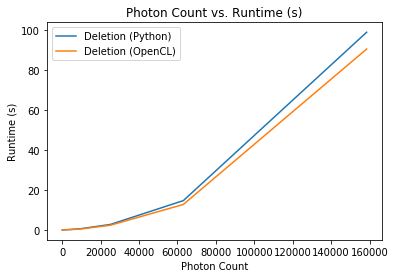

In [4]:
def del_prep(sim, i):
	sim.add_step(0, phys.UpdateTimeStep(lambda s: np.double(0.001)))
	sim.add_step(1, phys.newton.NewtonianKinematicsStep())
	sim.add_step(2, phys.light.ScatterDeleteStep(np.double(0.001), np.double(0.001)))

	sim.add_objs(phys.light.generate_photons(i, bins=1, dist="constant", min=phys.light.E_from_wavelength(200e-9), max=phys.light.E_from_wavelength(700e-9)))

comp(del_prep, action="Deletion")

## Spherical Scattering 
As can be seen in the plot below, spherical scattering performs noticeably better when we turn OpenCL on.

In [5]:
def sphere_prep(sim, i):
	sim.exit = lambda cond: cond.t >= 0.5
	sim.add_step(0, phys.UpdateTimeStep(lambda s: np.double(0.001)))
	sim.add_step(1, phys.newton.NewtonianKinematicsStep())
	sim.add_step(2, phys.light.ScatterSphericalStep(np.double(0.001), np.double(0.001)))

	sim.add_objs(phys.light.generate_photons(i, bins=1, dist="constant", min=phys.light.E_from_wavelength(200e-9), max=phys.light.E_from_wavelength(700e-9)))


100.0 CL off
0.5191032886505127
100.0 CL on
1.5218040943145752
251.0 CL off
1.2490413188934326
251.0 CL on
2.126352310180664
630.0 CL off
3.0626182556152344
630.0 CL on
3.6421561241149902
1584.0 CL off
8.15613317489624
1584.0 CL on
7.431457996368408
3981.0 CL off
20.75679612159729
3981.0 CL on
17.149813175201416
10000.0 CL off
51.40504503250122
10000.0 CL on
42.90073871612549
25118.0 CL off
129.61825227737427
25118.0 CL on
104.1341335773468
63095.0 CL off
325.26566648483276
63095.0 CL on
276.1433503627777
158489.0 CL off
820.4693002700806
158489.0 CL on
710.1396863460541


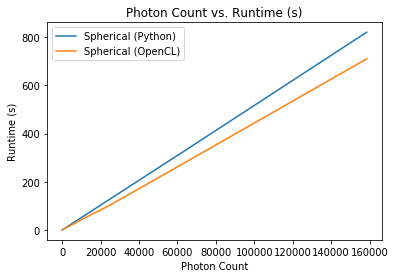

In [6]:
comp(sphere_prep, action="Spherical")

## Spherical Scattering with Wavelength Dependent Scattering
This step performs significantly better with OpenCL on. This significant divergence is likely caused by the addition of the $\frac{1}{\lambda^4}$ term when we add wavelength-dependent scattering.

In [7]:
def sphere_wav_prep(sim, i):
	sim.exit = lambda cond: cond.t >= 0.5
	sim.add_step(0, phys.UpdateTimeStep(lambda s: np.double(0.001)))
    sim.add_step(1, phys.newton.NewtonianKinematicsStep())
	sim.add_step(2, phys.light.ScatterSphericalStep(np.double(0.001), np.double(0.001), wavelength_dep_scattering = True))

	sim.add_objs(phys.light.generate_photons(i, bins=1, dist="constant", min=phys.light.E_from_wavelength(200e-9), max=phys.light.E_from_wavelength(700e-9)))


100.0 CL off
0.8333532810211182
100.0 CL on
1.6596975326538086
251.0 CL off
2.0524051189422607
251.0 CL on
2.3381969928741455
630.0 CL off
4.987109422683716
630.0 CL on
5.033101797103882
1584.0 CL off
12.675144672393799
1584.0 CL on
8.514382600784302
3981.0 CL off
32.13300395011902
3981.0 CL on
19.79353952407837
10000.0 CL off
79.3143322467804
10000.0 CL on
48.07356548309326
25118.0 CL off
200.77089953422546
25118.0 CL on
118.96156764030457
63095.0 CL off
510.03820848464966
63095.0 CL on
310.2140290737152
158489.0 CL off
1272.8168892860413
158489.0 CL on
796.477044582367


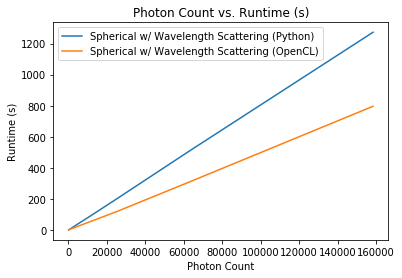

In [8]:
comp(sphere_wav_prep, action="Spherical w/ Wavelength Scattering")

As can be seen from the plots, OpenCL can save us significant amounts of time despite the overhead of copying data to an OpenCL device, so long as the operations we perform are significantly taxing. 